<a href="https://colab.research.google.com/github/teng-tt/PlantVillage-Dataset/blob/master/Corn_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 玉米叶部病害识别
使用公开的PlantVillage作为样本


#下载数据集
数据集使用PlantVillage提供的公开数据，此处我们只取玉米的病害进行图像识别

In [ ]:
# 基于文件id进行文件下载
# file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# 下载数据集
# !gdown https://drive.google.com/uc?id={file_id}

# 解压下载文件
!unzip -q PlantVillage.zip

# 导入依赖库
使用TensorFlow后端


In [21]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam_v2, gradient_descent_v2 
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# 加载数据集

In [22]:
# 定义初始图片大小
DEFAULT_IMAGE_SIZE = tuple((256, 256))
# 定义训练模型图片数量
N_IMAGE = 400
# 定义数据集路径
root_dir = './PlantVillage'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

定义图片转换函数

In [23]:
def convertImageToArray(image_dir):
    """
    调整输入图片尺寸
    :param image_dir: 图片文件路径
    :return:
    """
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print("Error : {e}".format(e=e))
        return None

加载数据集并转换图片大小

In [24]:
imageList, labelList = [], []
try:
    print("[INFO] Loading images ...")
    plantDiseaseFolderList = os.listdir(train_dir)

    for plantDiseaseFolder in plantDiseaseFolderList:
        print("[INFO] Processing {} ...".format(plantDiseaseFolder))
        plantDiseaseImageList = os.listdir("{}/{}/".format(train_dir, plantDiseaseFolder))

        for image in plantDiseaseImageList[:N_IMAGE]:
            imageDirectory = "{}/{}/{}".format(train_dir, plantDiseaseFolder, image)
            if imageDirectory.endswith(".jpg") == True or imageDirectory.endswith(".JPG") == True:
                imageList.append(convertImageToArray(imageDirectory))
                labelList.append(plantDiseaseFolder)
    print("[INFO] Image loading completed")
except Exception as e:
    print("Error : {}".format(e))

# 将训练数据集转换为 numpy 数组
npImageList = np.array(imageList, dtype=np.float16) / 225.0
print()
# 检查加载的训练集图片数量
imaeLen = len(imageList)
print("Total number of images: {}".format(imaeLen))

[INFO] Loading images ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Image loading completed

Total number of images: 1600


将病害数据与图片进行标注,将每种植物病害的每个标签或类别映射到训练任务的唯一值
此外，将此转换保存到文件将有助于稍后从分类模型的输出中预测植物病害的标签或类别

In [25]:
# 检查训练数据集中的标签/类别。
labelBinarize = LabelBinarizer()
imageLabels = labelBinarize.fit_transform(labelList)
pickle.dump(labelBinarize, open("plantDiseaseLabelTransform.pkl", "wb"))
nClasses = len(labelBinarize.classes_)
print("Total number of classes: {}".format(nClasses))

Total number of classes: 4



# 增强和拆分数据集

使用ImageDataGenerator通过对训练图像进行各种操作，以增加数据。

In [26]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True,
                             fill_mode="nearest")

将数据拆分为训练集和测试集以进行验证，分割比0.2

In [27]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(npImageList, imageLabels, test_size=0.2, random_state=42)

[INFO] Splitting data to train and test...


# 构建模型

定义植物病害分类模型的超参数。

In [28]:
# 迭代25轮，每轮迭代100次，每批次32个样本
EPOCHS = 25 
STEPS = 100
LR = 1e-3
# BATCH_SIZE 设置一个batch为含有32个样本的集合，每一个batch的样本都是独立并行处理的
# 在训练时，一个 batch 的结果只会用来更新一次模型
BATCH_SIZE = 32
# 图片像素256*256*3 RGB3通道
WIDTH = 256
HEIGHT = 256
DEPTH = 3

创建序列模型并在适当的位置添加卷积、归一化、池化、Dropout 和激活层。

In [29]:
# 初始化模型，使用Keras的顺序模型
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

# 卷积层 Conv2D图像空间的2维卷积,inputShape：输入3通道256*256像素图像-(256, 256, 3)张量
# 使用 Conv2D(32, (3, 3) ：32 个大小为 3x3 的卷积滤波器。
# 卷积、标准化、池化、正则化
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=inputShape))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# 卷积、标准化、卷积、标准化、池化、正则化
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 卷积、标准化、卷积、标准化、池化、正则化
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 展平输入、全连接、激活、正则化、全连接、激活
model.add(Flatten())
# 全连接层输出维度1024
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
# 全连接层输出维度为分类类别数
model.add(Dense(nClasses))
model.add(Activation("softmax"))
# 模型概览
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_15 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 85, 85, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 85, 85, 64)        18496     
                                                                 
 batch_normalization_16 (Bat  (None, 85, 85, 64)      

# 训练模型

我们用学习率和衰减参数初始化 Adam 优化器。

此外，我们为模型选择损失类型和指标，并对其进行编译以进行训练。

In [30]:
# 初始化优化器 使用Adam优化
# lr=学习率  decay=衰减率
# opt = adam_v2.Adam(learning_rate=LR, decay=LR / EPOCHS)
opt = gradient_descent_v2.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
# 编译模型
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# 输出网络结构图
plot_model(model, to_file='./model2.png', show_shapes=True)
print("[INFO] Training network...")
# 训练模型
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


[INFO] Training network...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/25
40/40 [==============================] - 282s 7s/step - loss: 0.8503 - accuracy: 0.6820 - val_loss: 10.1249 - val_accuracy: 0.2188
Epoch 2/25
40/40 [==============================] - 280s 7s/step - loss: 0.2309 - accuracy: 0.7891 - val_loss: 0.5708 - val_accuracy: 0.5000
Epoch 3/25
40/40 [==============================] - 278s 7s/step - loss: 0.1832 - accuracy: 0.8148 - val_loss: 0.5468 - val_accuracy: 0.4625
Epoch 4/25
40/40 [==============================] - 281s 7s/step - loss: 0.1851 - accuracy: 0.8359 - val_loss: 0.5448 - val_accuracy: 0.5125
Epoch 5/25
40/40 [==============================] - 281s 7s/step - loss: 0.1771 - accuracy: 0.8469 - val_loss: 1.0100 - val_accuracy: 0.4469
Epoch 6/25
40/40 [==============================] - 280s 7s/step - loss: 0.1642 - accuracy: 0.8687 - val_loss: 1.1591 - val_accuracy: 0.4938
Epoch 7/25
40/40 [==============================] - 284s 7s/step - loss: 0.1431 - accuracy: 0.8727 - val_loss: 1.2262 - val_accuracy: 0.4781
Epoch 8/25
4

#评估模型

通过绘制训练和验证图来比较准确率和损失。

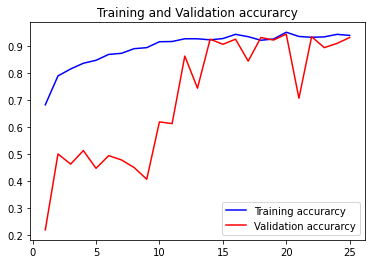

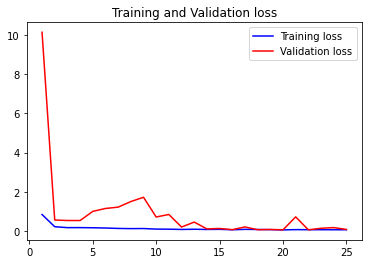

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# 训练集与测试集精度
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# 训练集与测试集损失率
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

使用该evaluate方法评估模型精度

In [32]:
print("[INFO] 计算模型精度")
scores = model.evaluate(x_test, y_test)
print("测试精度: {}".format(scores[1]*100))

[INFO] 计算模型精度
10/10 [==============================] - 16s 2s/step - loss: 0.0931 - accuracy: 0.9312
测试精度: 93.12499761581421


#保存模型

In [35]:
# 保存模型文件
print("[INFO] Saving model...")
pickle.dump(model,open('./plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...
INFO:tensorflow:Assets written to: ram://5bc11479-b1fc-4f33-8469-309b0d779184/assets


INFO:tensorflow:Assets written to: ram://5bc11479-b1fc-4f33-8469-309b0d779184/assets


In [46]:
# 保存标签文件
print("[INFO] Saving label transform...")
filename = './plantDiseaseLabelTransform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


# 测试模型

我们编写以下predict_disease函数来预测植物图像的类别或疾病。

我们只需要提供图像的完整路径，它就会显示图像及其预测类别或植物病害。

In [52]:
def predict_disease(image_path):
    image_array = convertImageToArray(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    predict = model.predict(np_image)
    predict = np.argmax(predict,axis=1)
    result = predict # model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

Corn_(maize)___Common_rust_


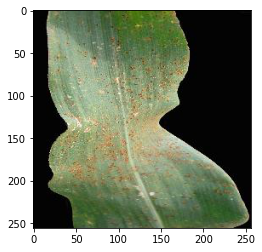

In [53]:
predict_disease('/content/PlantVillage/val/Corn_(maize)___Common_rust_/RS_Rust 1568.JPG')

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


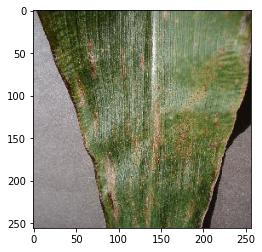

In [54]:
predict_disease('/content/PlantVillage/val/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/065fe7da-dcaf-41be-9332-5ec5ebceb94b___RS_GLSp 9337.JPG')

Corn_(maize)___Northern_Leaf_Blight


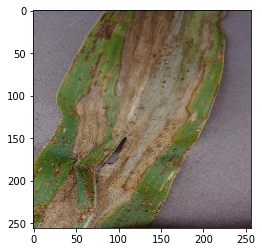

In [55]:
predict_disease('/content/PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/005318c8-a5fa-4420-843b-23bdda7322c2___RS_NLB 3853 copy.jpg')

Corn_(maize)___healthy


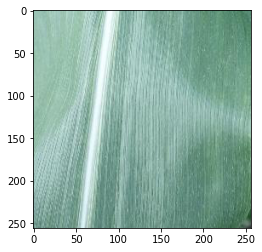

In [56]:
predict_disease('/content/PlantVillage/val/Corn_(maize)___healthy/01c3bf88-d315-42a3-8fa1-fc80a05c97f1___R.S_HL 8189 copy.jpg')

# 重用模型

加载保存在 Google Drive 中的训练模型和标签转换。

导入构建分类模型所需的必要库和模块。

In [57]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam_v2, gradient_descent_v2 
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

加载经过训练的模型及其标签以进行预测。

In [58]:
# 加载模型
filename = 'plant_disease_classification_model.pkl'
model = pickle.load(open(filename, 'rb'))

# 加载标签
filename = 'plantDiseaseLabelTransform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

我们使用convert_image_to_array函数来调整图像大小和predict_disease函数来预测植物图像的类别或疾病。

我们只需要提供图像的完整路径，它就会显示图像及其预测类别或植物病害。

In [61]:
# 调整图像大小尺寸
DEFAULT_IMAGE_SIZE = tuple((256, 256))

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    predict = model.predict(np_image)
    predict = np.argmax(predict,axis=1)
    result = predict
    print((image_labels.classes_[result][0]))

预测玉米叶部图像的疾病。

Corn_(maize)___Northern_Leaf_Blight


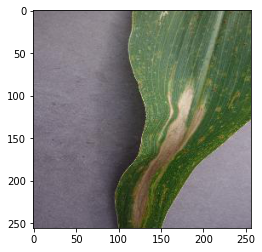

In [62]:
predict_disease('/content/PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/028159fc-995e-455a-8d60-6d377580a898___RS_NLB 4023.JPG')

Corn_(maize)___Northern_Leaf_Blight


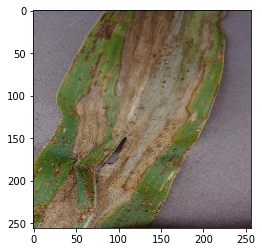

In [63]:
predict_disease('/content/PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/005318c8-a5fa-4420-843b-23bdda7322c2___RS_NLB 3853 copy.jpg')

In [64]:
import time

Corn_(maize)___Northern_Leaf_Blight
time cost 0.17972850799560547 s


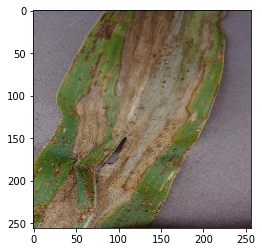

In [66]:
time_start=time.time()
predict_disease('/content/PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/005318c8-a5fa-4420-843b-23bdda7322c2___RS_NLB 3853 copy.jpg')
time_end=time.time()
print('time cost',time_end-time_start,'s')

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
time cost 0.14609527587890625 s


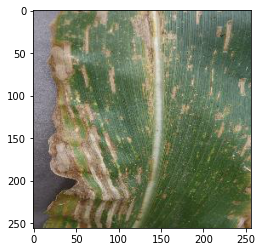

In [78]:
time_start=time.time()
predict_disease('/content/PlantVillage/train/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/0dbbcb82-756e-48a6-94f4-3a8f1e1cedda___RS_GLSp 4587.JPG')
time_end=time.time()
print('time cost',time_end-time_start,'s')

Corn_(maize)___Common_rust_
time cost 0.1697404384613037 s


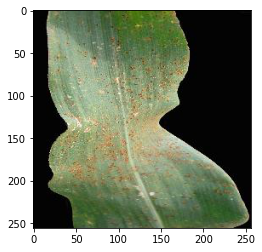

In [68]:
time_start=time.time()
predict_disease('/content/PlantVillage/val/Corn_(maize)___Common_rust_/RS_Rust 1568.JPG')
time_end=time.time()
print('time cost',time_end-time_start,'s')

Corn_(maize)___healthy
time cost 0.16346383094787598 s


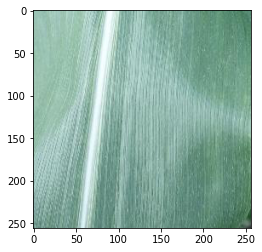

In [69]:
time_start=time.time()
predict_disease('/content/PlantVillage/val/Corn_(maize)___healthy/01c3bf88-d315-42a3-8fa1-fc80a05c97f1___R.S_HL 8189 copy.jpg')
time_end=time.time()
print('time cost',time_end-time_start,'s')

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
time cost 0.20931029319763184 s


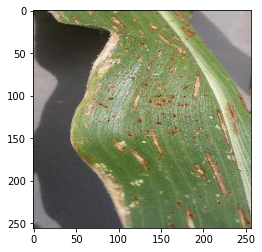

In [70]:
time_start=time.time()
predict_disease('/content/PlantVillage/val/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/06785548-9756-4410-b3c2-55cc089276ce___RS_GLSp 4288.JPG')
time_end=time.time()
print('time cost',time_end-time_start,'s')

Corn_(maize)___Common_rust_
time cost 0.17782020568847656 s


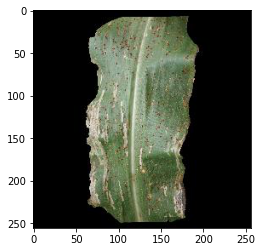

In [71]:
time_start=time.time()
predict_disease('/content/PlantVillage/val/Corn_(maize)___Common_rust_/RS_Rust 1605.JPG')
time_end=time.time()
print('time cost',time_end-time_start,'s')

Corn_(maize)___Northern_Leaf_Blight
time cost 0.16574597358703613 s


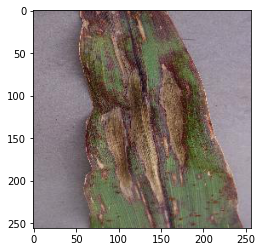

In [76]:
time_start=time.time()
predict_disease('/content/PlantVillage/train/Corn_(maize)___Northern_Leaf_Blight/08d875b9-7d0d-48af-9b27-e1fe9d1de96c___RS_NLB 3957.JPG')
time_end=time.time()
print('time cost',time_end-time_start,'s')

Corn_(maize)___healthy
time cost 0.16121578216552734 s


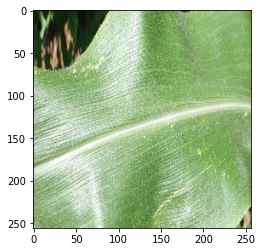

In [73]:
time_start=time.time()
predict_disease('/content/PlantVillage/val/Corn_(maize)___healthy/0f6d1e23-9ac3-4d2d-bd32-9b0cb91bf4e3___R.S_HL 0625 copy.jpg')
time_end=time.time()
print('time cost',time_end-time_start,'s')